<div style="text-align: center; margin: 50px">

<h1 style="text-align: center;">Qubit by Qubit - Semester 2</h1>
<h3>Grover´s Algorithm</h3>

</div>

# Overview 
1. [Introduction](#introduction)
2. [Implementing Grover's algorithm for 2 Qubits](#2qubits)
    1. [Step 1: Applying H gates](#hgates)
    2. [Step 2: Applying oracle and diffusion operator](#oracle2q)
    3. [Step 3: Measurement](#measurement)
    4. [Simulating the Circuit](#simulating)
    5. [Experiment with Real Devices](#real)
3. [Extra content](#extra)
    1. [Amplitude Amplification](#ampamp)
    2. [More qubits](#moreq)
    3. [Challenge questions](#challenge)

<a id="introduction"></a>
# 1. Introduction

Grover's algorithm is a quantum algorithm for searching an unsorted database with $N$ entries in $O(\sqrt{N})$ time and using $O(\log N)$ storage space. It was invented by [Lov Grover](https://en.wikipedia.org/wiki/Lov_Grover) in 1996.

Classically, searching an unsorted database requires a linear search, which is $O(N)$ in time. Grover's algorithm, which takes $O(\sqrt{N})$ time, is the fastest possible quantum algorithm for searching an unsorted database. It provides "only" a quadratic speedup, unlike other quantum algorithms, which can provide exponential speedup over their classical counterparts. However, even quadratic speedup is considerable when $N$ is large. To achieve this, the amplitude amplification trick is used.

Like all quantum computer algorithms, Grover's algorithm is probabilistic, in the sense that it gives the correct answer with high probability. The probability of failure can be decreased by repeating the algorithm.

<a id="unstructured"></a>
## Unstructured Search

Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. Think of each item in the list as a box of a particular color. Say all items in the list are gray except the winner $w$, which is blue.

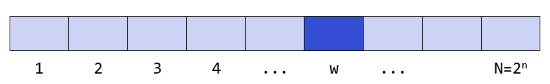

To find the blue box (the marked item) using classical computation, one would have to check on average $N/2$ of these boxes, and in the worst case, all $N$ of them (i.e. linear search because it is an unstructured data set). On a quantum computer, however, we can find the marked item in roughly $\sqrt{N}$ steps. A quadratic speedup is indeed a substantial time-saver for finding marked items in long lists. Additionally, the algorithm does not use the list's internal structure, which makes it generic; this is why it immediately provides a quadratic quantum speed-up for many classical problems.

<a id="2qubits"></a>
# 2. Implementing the Grover circuit for 2 qubits

Let's do the necessary imports:

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import *
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Remember that we want to implement the following three steps:

1. Apply H gate to both qubits : **to create the uniform superposition of the number of qubits required to represent your list length**
2. Apply oracle and Grover's diffusion operator to both qubits : **this is where the speedup actually takes place because the ORACLE IS APPLIED PARALELLY**
3. Measure both qubits

Here is the final circuit we want to create:

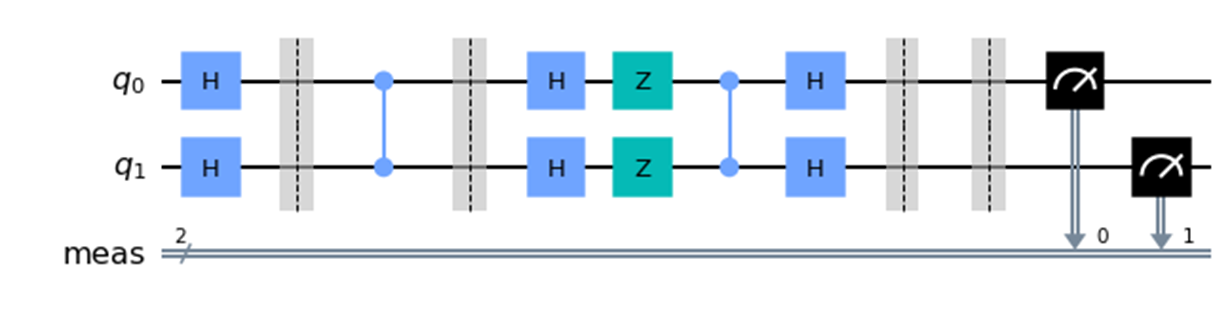

Then we simply need to write out the commands for the circuit depicted above. Let's implement each step one-by-one:

<a id="hgates"></a>
## 2.1 Step 1: Applying H gates

We'll create a function `initialize` that applies H gates to both input qubits. It takes the quantum circuit as the input.
- By applying the H gates we are representing ALL THE STATES POSSIBLE AT ONCE

In [24]:
def initialize(qc):
    """Apply a H-gate to the 2 qubits in qc"""
    qc.h([0,1])
    qc.barrier()
    return qc

Let's run the function to check if we got it right!

In [25]:
q = QuantumCircuit(2)
grover_circuit =  initialize(q)#Create a 2 qubit quantum circuit
# Call the initialize function

grover_circuit.draw('mpl')

## TENSOR PRODUCTs

In [26]:
H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]])
hh = np.kron(H,H)
s1 = np.array([[1,0,0,0]]) # the |00> state 
s1 = np.transpose(s1)
print("HADAMARD tensor :\n",hh)
print("Final state : ")
print(hh@s1)
print("This represents that H tensor H would produce the equal superposition")

HADAMARD tensor :
 [[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]
Final state : 
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
This represents that H tensor H would produce the equal superposition


<a id="oracle2q"></a>
## 2.2 Step 2: Applying the oracle and Grover's diffusion operator

- Oracle is a way of **marking the element we are looking for but not changing the nature of the state**
- Since our winner state is **|11>**, we need an oracle which implements **|11>** goes to **-|11>**
Remember that the oracle matrix we want to implement is given by:

$$
U_w = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

which you may recognise as the controlled-Z gate. Thus, for this example, our oracle is simply the controlled-Z gate.

We'll implement the oracle as a function `oracle_11`. The `11` indicates that this is the oracle in case the element we want to find is in the 4th position.

In [27]:
def oracle_11(qc):
    """Apply a controlled Z gate with qubit 0 as control and qubit 1 as target"""
    qc.cz(0,1)
    qc.barrier()
    return qc

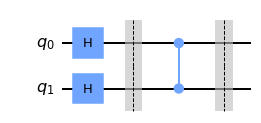

In [28]:
# Call the oracle_11 function
grover_circuit = oracle_11(grover_circuit)
grover_circuit.draw('mpl')

## TENSOR PRODUCTS

In [29]:
cz = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
state = 0.5*np.array([[1],
                      [1],
                      [1],
                      [1]])
print("We have flipped the sign with this oracle :")
print(cz @ state)

We have flipped the sign with this oracle :
[[ 0.5]
 [ 0.5]
 [ 0.5]
 [-0.5]]


## Diffusion operator
- How to go from the 0.5 * [1,1,1,-1] state to the [0,0,0,1] ?

Next, we will apply Grover's diffusion operator, whose matrix is given by:

$$ \frac{1}{2}
\begin{bmatrix}
-1 & 1 & 1 & 1 \\
1 & -1 & 1 & 1 \\
1 & 1 & -1 & 1 \\
1 & 1 & 1 & -1 \\
\end{bmatrix}
$$

And the circuit for this operator is given by:

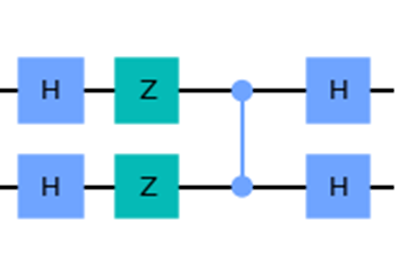

We'll implement the operator as a function `u_g`, which takes the quantum circuit as an input and applies the required gates:

In [30]:
def u_g(qc):
    """Apply the gates necessary for the diffusion operator"""
    qc.h([0,1])
    qc.z([0,1])
    qc.cz(0,1)
    qc.h([0,1])
    qc.barrier()
    return qc

In [31]:
# Call the u_g functionm
grover_circuit = u_g(grover_circuit)
grover_circuit.draw('mpl')

## TENSOR PRODUCTs

In [32]:
diffuse = 0.5*np.array([[-1,1,1,1],
                   [1,-1,1,1],
                   [1,1,-1,1],
                   [1,1,1,-1]])
state = 0.5 * np.array([[1],[1],[1],[-1]])
print("Operator :\n",diffuse)
print("State :\n",state)
print("Final :\n",diffuse @ state)

Operator :
 [[-0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5  0.5]
 [ 0.5  0.5 -0.5  0.5]
 [ 0.5  0.5  0.5 -0.5]]
State :
 [[ 0.5]
 [ 0.5]
 [ 0.5]
 [-0.5]]
Final :
 [[0.]
 [0.]
 [0.]
 [1.]]


## So we actually do have our result!

<a id="measurement"></a>
## 2.3 Step 3: Measurement

Finally, we can add measurements to our circuit. We'll use a slightly different way of adding measurements today- we'll use the function `measure_all()` to directly add classical bits and measurements to our circuit.

In [33]:
grover_circuit.measure_all()
grover_circuit.draw('mpl')

<a id="simulating"></a>
## 2.4 Simulating the Circuit

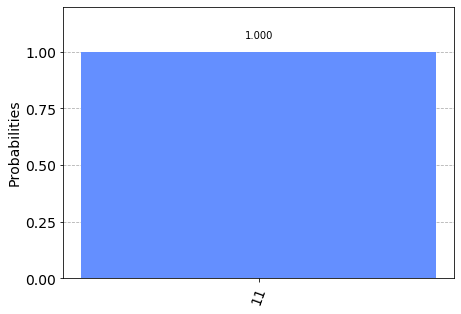

In [35]:
backend = Aer.get_backend('qasm_simulator')
job = execute(grover_circuit, backend, shots = 1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

<a id="real"></a>
## 2.5 Experiment with Real Devices

We can run the circuit a real device as below.

In [52]:
# Load local account information
# IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_16_melbourne


In [53]:
def get_grover():
    q = QuantumCircuit(2)
    grover_circuit =  initialize(q)
    grover_circuit = oracle_11(grover_circuit)
    grover_circuit = u_g(grover_circuit)
    display(grover_circuit.draw('mpl'))
    return grover_circuit

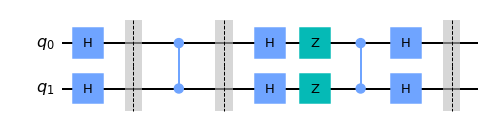

Job Status: job is queued (None)

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
grover_circuit = get_grover()
transpiled_grover_circuit = transpile(grover_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_grover_circuit)
job = backend.run(qobj)
job_monitor(job, interval=2)

In [ ]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

What differences do you notice between this plot and the one from the simulation? 

<a id="extra"></a>
# 3. Extra content - to do...

<a id="ampamp"></a>
## 3.1 Amplitude Amplification

Before looking at the list of items, we have no idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a
uniform superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

If at this point we were to measure in the standard basis $\{ | x \rangle \}$, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of $\frac{1}{N} = \frac{1}{2^n}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about $N/2 = 2^{n-1}$ times to guess the correct item.

Enter the procedure called **amplitude amplification**, which is how a quantum computer significantly enhances this probability. This procedure stretches out (amplifies) the amplitude of the marked item, which shrinks the other items' amplitude, so that measuring the final state will return the right item with near-certainty. 

This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $| w \rangle$ and the uniform superposition $| s \rangle$. These two vectors span a two-dimensional plane in the vector space $\mathbb{C}^N.$ They are not quite perpendicular because $| w \rangle$ occurs in the superposition with amplitude $N^{-1/2}$ as well.
We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and
rescaling. 

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$.

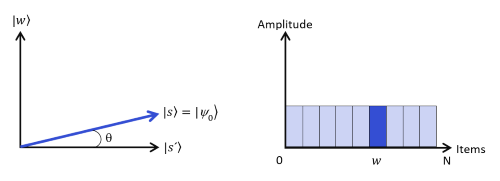

The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$.

**Step 2**: We apply the oracle reflection $U_f$ to the state $|s\rangle$.

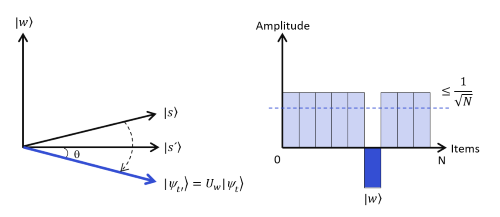

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

**Step 3**: We now apply an additional reflection ($U_s$) about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - \mathbb{1}$. This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation. 

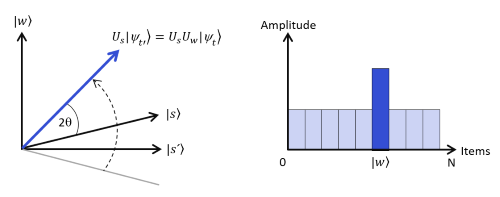

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. 

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

How many times do we need to apply the rotation? It turns out that roughly $\sqrt{N}$ rotations suffice. This becomes clear when looking at the amplitudes of the state $| \psi \rangle$. We can see that the amplitude of $| w \rangle$ grows linearly with the number of applications $\sim t N^{-1/2}$. However, since we are dealing with amplitudes and not probabilities, the vector space's dimension enters as a square root. Therefore it is the amplitude, and not just the probability, that is being amplified in this procedure.

In the case that there are multiple solutions, $M$, it can be shown that roughly $\sqrt{(N/M)}$ rotations will suffice.


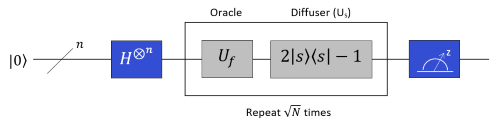

<a id="moreq"></a>
## 3.2 More qubits

If we want to solve problems more complex, such as looking for a number in a much larger data set, it is necessary to use more qubits.

How would you find the marked number in this box?

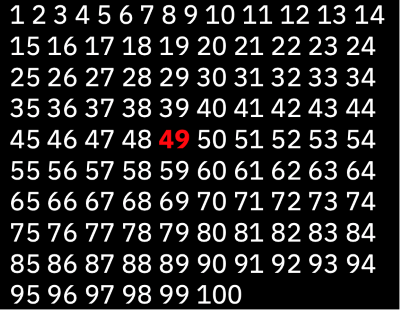

To illustrate this example, of the search in a box of numbers, we will use a code previously developed by A. Asfaw ([here](https://github.com/aasfaw/ieee-quantum-week-2020)). Which allows us to create a box with the amount of numbers that we want, for example 8 and according to that size it will be in charge of creating the necessary qubits, and in this example $2^n = 8$, therefore $n = 3$. Randomly a number will be chosen to look for inside the box.

In [45]:
from marked_number_boxes import quantum_box, find_number_in_quantum_box

ModuleNotFoundError: No module named 'marked_number_boxes'

In [ ]:
max_number = 8
my_box = quantum_box(max_number, print_self = True)

Let's see what the circuit looks like for this example.

In [ ]:
quantum_program = find_number_in_quantum_box(my_box)
quantum_program.draw('mpl')

By simulating the previous circuit, the following probabilities are obtained:

In [ ]:
quantum_program = find_number_in_quantum_box(my_box, show_results = True)

As we can see, the highest probability corresponds to the number to be searched (defined at the beginning randomly).

**Qiskit implements Grover’s algorithm** in the `Grover` [class](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Grover.html). This class also includes the generalized version, Amplitude Amplification, and allows setting individual iterations and other meta-settings to Grover’s algorithm.

To run Grover’s algorithm with the `Grover` class, firstly, we need to specify an oracle for the circuit of Grover’s algorithm.

To create the oracle, we use the `LogicalExpressionOracle` class, to which the constraints are indicated in the form of a string, to know more about this class you can review this [tutorial](https://qiskit.org/documentation/tutorials/algorithms/07_grover.html).

First we show the grover circuit and we can see that in the large rectangle we have the implementation of the oracle and the diffuser, in the next cell the `grover_operator` is shown that includes both parts.

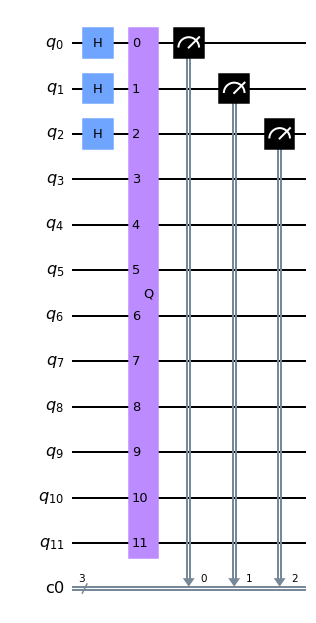

In [46]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle

input_constraints = \
'''
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

oracle = LogicalExpressionOracle(input_constraints)
grover = Grover(oracle)
grover.construct_circuit(measurement=True).draw('mpl')

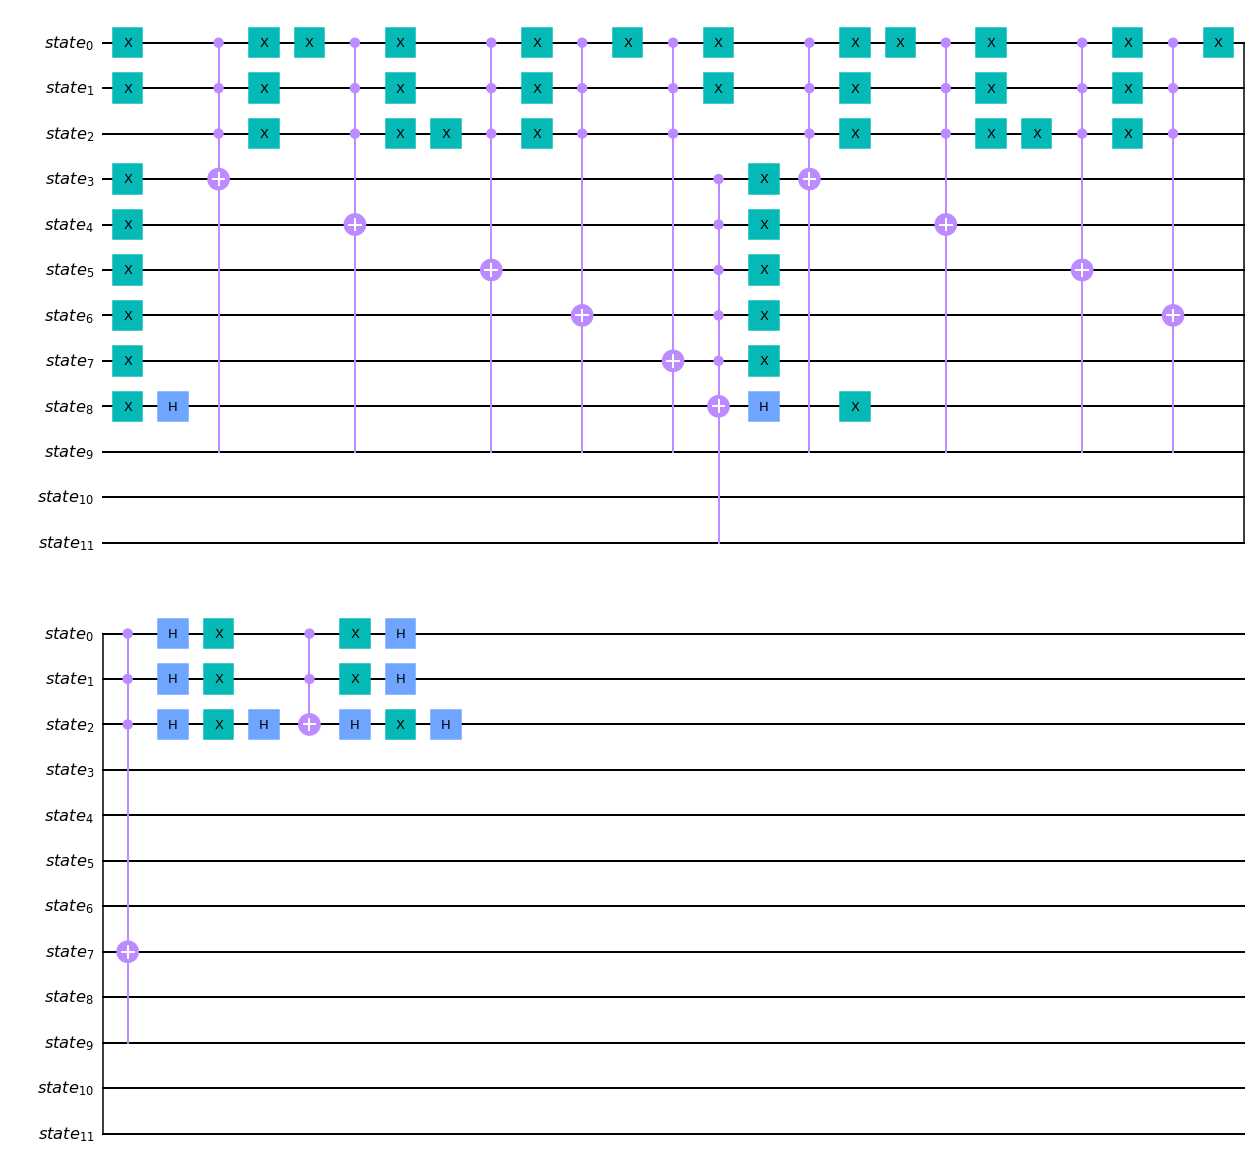

In [47]:
grover.grover_operator.draw('mpl')

## 3.3 Challenge questions

1. Using the `Grover` class, create a full implementation of a 2 qubit Grover search algorithm. Is the circuit the same as what we developed in the lab?
2. Using the `Grover` class, create a full implementation of a 5 qubit Grover search algorithm. Try running it on hardware. What is the success probability?